# Context

You have to consider a cable-driven parallel robot with 2 cables and 2 degrees of freedom.
The robot is actuated by changing the length of the 2 cables. This makes the effector (fixed by the 2 cables) moving.

Cables are fixed on a wall at position (0,5) and (5,5). Cable lengths $l_1$ and $l_2$ can vary from 0 to 5.

As an example, you can see a static position (1,4) of the robot and an animation when it moves from this initial position:

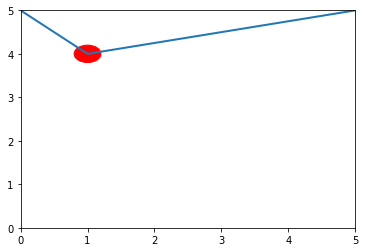

In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib import animation, rc
from IPython.display import HTML
%matplotlib inline
import numpy as np

# Static figure
fig, ax = plt.subplots()

ax.set_xlim(( 0, 5))
ax.set_ylim((0, 5))

line, = ax.plot([0,1,5], [5,4,5], lw=2)
effector = Circle((1,4),radius=0.2,color='red')
ax.add_patch(effector)


In [2]:
# Animation

def init():
    line.set_data([0,1,5], [5,4,5])
    effector.center=(1,4)
    return (line,effector)

n_frame=100

# animation function. This is called sequentially
def animate(i):
    x,y = line.get_data()
    x[1] += 3/n_frame
    if i<=n_frame/2:
        y[1] -= 5/n_frame
    else: 
        y[1] += 3/n_frame
    line.set_data(x, y)
    effector.center=(x[1],y[1])
    return (line,effector)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=n_frame, interval=10, blit=True)

HTML(anim.to_jshtml())

## Generic modeling

In robotic, most models are expressed like a system of equations:
$$M(x,q)=0$$
where $x$ is a vector corresponding to the coordinates of the robot effector and $q$ is a vector corresponding the commands for the actuators.

In our case with 2 cables and 2 DoF robot, $x$ and $q$ have a size of 2.


## Inverse Model

The model computing the commands from a given position is called the inverse model:
$$M_1(x) \rightarrow q$$

The following figure allows you to play with the effector position to get the vizualisation of the robot:

In [3]:
import ipywidgets as widgets

a1=np.array([0.,5.])
a2=np.array([5.,5.])

x_data=np.array([0.,1.,5.])
y_data=np.array([5.,4.,5.])

def update_plot(x,y):
    fig1, ax1 = plt.subplots()
    ax1.set_xlim((0, 5))
    ax1.set_ylim((0, 5))
    x_data[1] = x
    y_data[1] = y

    eff1=Circle((x,y),radius=0.2,color='red')
    ax1.add_patch(eff1)
    plt.plot(x_data,y_data)

w = widgets.interactive(update_plot,x=(0.0,5.0),y=(0.0,5.0))
display(w)

interactive(children=(FloatSlider(value=2.5, description='x', max=5.0), FloatSlider(value=2.5, description='y'…

### Questions

1. Define the mathematical model for the inverse problem.
2. Implement it and validate it using the previous figure.


In [4]:
import ipywidgets as widgets
def inverse_model(x):
  l1= ((0-x[0])**2 + (5-x[1])**2)**(1/2)
  l2= ((5-x[0])**2 + (5-x[1])**2)**(1/2)
  return np.array([l1,l2])

a1=np.array([0.,5.])
a2=np.array([5.,5.])

x_data=np.array([0.,1.,5.])
y_data=np.array([5.,4.,5.])

def update_plot(x,y):
    fig1, ax1 = plt.subplots()
    ax1.set_xlim((0, 5))
    ax1.set_ylim((0, 5))
    x_data[1] = x
    y_data[1] = y
    eff1=Circle((x,y),radius=0.2,color='red')
    ax1.add_patch(eff1)
    l1=inverse_model([x,y])[0]
    circle1= Circle((0,5),radius=l1, fill =False)
    ax1.add_patch(circle1)
    l2=inverse_model([x,y])[1]
    circle1= Circle((5,5),radius=l2, fill =False)
    ax1.add_patch(circle1)
    plt.plot(x_data,y_data)

w = widgets.interactive(update_plot,x=(0.0,5.0),y=(0.0,5.0))
display(w)

interactive(children=(FloatSlider(value=2.5, description='x', max=5.0), FloatSlider(value=2.5, description='y'…

## Direct Model

This model give the effector position from commands:
$$M_2(q) \rightarrow x$$

In the case of a cable-driven robot, this model requires to solve a system of equations.

### Background on Newton's method for finding roots

One of the most famous methods to solve a system of nonlinear equation is the Newton's method (https://en.wikipedia.org/wiki/Newton%27s_method). This method requires to have a square system (the same number of equations and variables). It is an iterative method that computes a serie of approximate solutions.

Given a system of $n$ equations $F$ applying on a $n$ variables $x$, this method tries to find the $n$ values $x^*$ that satisfy: $F(x^*)=0$.

To do that, each step $k$ of this method computes a new approximation $x_k$ of $x^*$ using the following expression (based on previous solution $x_{k-1})$:

$$x_k = x_{k-1} - J_F(x_{k-1})^{-1}*F(x_{k-1})$$

where $J_F$ is the Jacobian matrix of $F$ (ie. the matrix of partial derivatives for each variable and for each equation).

Obtaining $x^*$ is almost impossible for at least 2 reasons: (1) numerical roundings during computations, (2) slow convergence on some problems. This iterative method has mainly 2 stopping criteria: (1) a maximum number of iterations and (2) the improvement between two steps.

Thus, to apply this method you should define the system, its paratial derivatives, a starting point, a maximum number of iterations and minimum improvement. You can mainly consider that your algorithm converged when the improvement criteria is met, otherwise there was a problem (bad values for parameters, slow convergence, divergence, etc.).


### Questions

1. Define this mathematical system.
2. Implement the Newton's algorithm to solve it.
3. Implement a vizualisation with sliders for q (ie. $l_1$, $l_2$) that calls your algorithm to compute the solution.

In [5]:
# import the necessary libraries
# from ast import Yield
import numpy as np
from numpy.linalg import inv, det

# define the mathematical function to be computed
def f(x, y, l1, l2):
    return np.array([np.sqrt(np.square(x) + np.square(y)-10*y + 25 )-l1 , np.sqrt(np.square(x) + np.square(y)-10*x-10*y + 50 )-l2])

# define the Jacobian matrix
def J(x, y, l1, l2):

    x1_dot = x/np.sqrt(x**2 + y**2 - 10*y + 25)
    y1_dot = (y - 5)/np.sqrt(x**2 + y**2 - 10*y + 25)
    x2_dot = (x - 5)/np.sqrt(x**2 - 10*x + y**2 - 10*y + 50)
    y2_dot = (y - 5)/np.sqrt(x**2 - 10*x + y**2 - 10*y + 50)


    return np.array([[x1_dot,y1_dot], [x2_dot,y2_dot]])

new_x=[]
new_y=[]

# solve the forward kinematics problem
def forward_model(x,y,l1,l2):
  # set the tolerance
  tolerance = 1e-6

  # set the maximum number of iterations
  max_iter = 10000
  for i in range(max_iter):
        # compute the function and Jacobian
        f_value = f(x, y, l1, l2)
        J_value = (J(x, y, l1, l2))

        # compute the update
#         update = list(np.linalg.solve(J_value, -f_value))
        try:
          update = np.linalg.solve(J_value, -f_value)
        except np.linalg.LinAlgError:
          update = [0.,0.]
          print("coordinates are not correct, try other coordinates")

        # update the cable length
        x += update[0]
        y += update[1]
        #l1=-l1
        new_x.append(x)
        new_y.append(y)
        # if l1<2.5 and l2<2.5:
        #     l1=2.5
        #     l2=2.5
            
        # if l1==5 and l2==0:
        #     l1=5
        #     l2=0
            
        # check for convergence
        if np.linalg.norm(update) < tolerance:
            break
  return x,y


In [6]:

a1=np.array([0.,5.])
a2=np.array([5.,5.])

x_data=np.array([0.,1.,5.])
y_data=np.array([5.,4.,5.])
def update_plot(l1,l2):
    fig1, ax1 = plt.subplots()
    ax1.set_xlim((0., 5.))
    ax1.set_ylim((0., 5.))
    x=forward_model(0.,0.,l1,l2)[0]
    y=forward_model(0.,0.,l1,l2)[1]
    x_data[1] = x
    y_data[1] = y
    eff1=Circle((x,y),radius=0.2,color='red')
    plt.plot(x_data,y_data)
    ax1.add_patch(eff1)
    plt.plot(x_data,y_data)

w = widgets.interactive(update_plot,l1=(0.0,5.0),l2=(0.0,5.0))
display(w)



interactive(children=(FloatSlider(value=2.5, description='l1', max=5.0), FloatSlider(value=2.5, description='l…

## Robot trajectory

We want know to vizualise the trajectory of the robot with a command law defined as followed:

- $l_1(t) = 1.2 + 3*sin(t*\pi/2)$
- $l_2(t) = 1.2 + 3*cos(t*\pi/2)$

where $t$ is the time evolving from 0 to 1.

### Questions

1. Compute all the commands values following this law discretizing the time with 100 steps.
2. Use your direct model and your Newton algorithm to compute all corresponding positions
3. Make an animation to vizualise the trajectory corresponding to this law

In [7]:
# # from ast import Yield
# # import the necessary libraries
# import numpy as np
# from numpy.linalg import inv, det
# import math

# # define the function to be computed
# def f(x, y, l1, l2):

#     return np.array([np.sqrt(np.square(x) + np.square(y)-10*y + 25 )-l1 , np.sqrt(np.square(x) + np.square(y)-10*x-10*y + 50 )-l2])

# # define the Jacobian matrix
# def J(x, y, l1, l2):
#     x1_dot = x/np.sqrt(x**2 + y**2 - 10*y + 25)
#     y1_dot = (y - 5)/np.sqrt(x**2 + y**2 - 10*y + 25)
#     x2_dot = (x - 5)/np.sqrt(x**2 - 10*x + y**2 - 10*y + 50)
#     y2_dot = (y - 5)/np.sqrt(x**2 - 10*x + y**2 - 10*y + 50)
#     l1_dot = -2*l1
#     l2_dot = -2*l2

#     return np.array([[x1_dot,y1_dot], [x2_dot,y2_dot]])

# # set the initial end-effector position
# x = 0
# y = 0

# # Create the time array
# t0=0
# t_end=1
# dt=0.01
# t=np.arange(t0,t_end+dt,dt)

# #define the desired length of each cable 
# theta1=t*math.pi/2
# theta2=t*math.pi/2
# l1 = 1.2+3*np.sin(theta1)
# l2 = 1.2+3*np.cos(theta2)

# # set the tolerance
# tolerance = 1e-6

# # set the maximum number of iterations
# max_iter = 100
# new_x=[]
# new_y=[]
# # solve the forward kinematics problem
# def forward_model2(x,y,l1,l2):
#     for j in range(len(t)):
#       for i in range(max_iter):
#           # compute the function and Jacobian
#           f_value = f(x, y, l1[j], l2[j])
#           J_value = J(x, y, l1[j], l2[j])

#           # compute the update
          
#           try:
#             update = np.linalg.solve(J_value, -f_value)
#           except np.linalg.LinAlgError:
#             update = [0,0]
         

#           # update the cable length
#           x += update[0]
#           y += update[1]
#           print(x)
        
       
#           #l1=-l1
#           # if x>0 and y>0 and x<5 and y<5:
#           new_x.append(x)
#           new_y.append(y)


#           # check for convergence
#           if np.linalg.norm(update) < tolerance:
#               break

#     return x,y

In [8]:
# from ast import Yield
# import the necessary libraries
import numpy as np
from numpy.linalg import inv, det
import math

# define the function to be computed
def f(x, y, l1, l2):

    return np.array([np.sqrt(np.square(x) + np.square(y)-10*y + 25 )-l1 , np.sqrt(np.square(x) + np.square(y)-10*x-10*y + 50 )-l2])

# define the Jacobian matrix
def J(x, y, l1, l2):
    x1_dot = x/np.sqrt(x**2 + y**2 - 10*y + 25)
    y1_dot = (y - 5)/np.sqrt(x**2 + y**2 - 10*y + 25)
    x2_dot = (x - 5)/np.sqrt(x**2 - 10*x + y**2 - 10*y + 50)
    y2_dot = (y - 5)/np.sqrt(x**2 - 10*x + y**2 - 10*y + 50)
    l1_dot = -2*l1
    l2_dot = -2*l2

    return np.array([[x1_dot,y1_dot], [x2_dot,y2_dot]])

# set the initial end-effector position
x = 0
y = 0

# Create the time array
t0=0
t_end=1
dt=0.01
t=np.arange(t0,t_end+dt,dt)

#define the desired length of each cable 
theta1=t*math.pi/2
theta2=t*math.pi/2
l1 = 1.2+3*np.sin(theta1)
l2 = 1.2+3*np.cos(theta2)

# set the tolerance
tolerance = 1e-6

# set the maximum number of iterations
max_iter = 100
new_x=[]
new_y=[]
# solve the forward kinematics problem
def forward_model2(x,y,l1,l2):
  for j in range(len(t)):
      for i in range(max_iter):
          # compute the function and Jacobian
          f_value = f(x, y, l1[j], l2[j])
          J_value = J(x, y, l1[j], l2[j])

          # compute the update
          try:
            update = np.linalg.solve(J_value, -f_value)
          except np.linalg.LinAlgError:
            update = [0,0]
          

          # update the cable length
          x += update[0]
          y += update[1]
          
          new_x.append(x)
          new_y.append(y)


          # check for convergence
          if np.linalg.norm(update) < tolerance:
              break
  return x,y, new_x, new_y


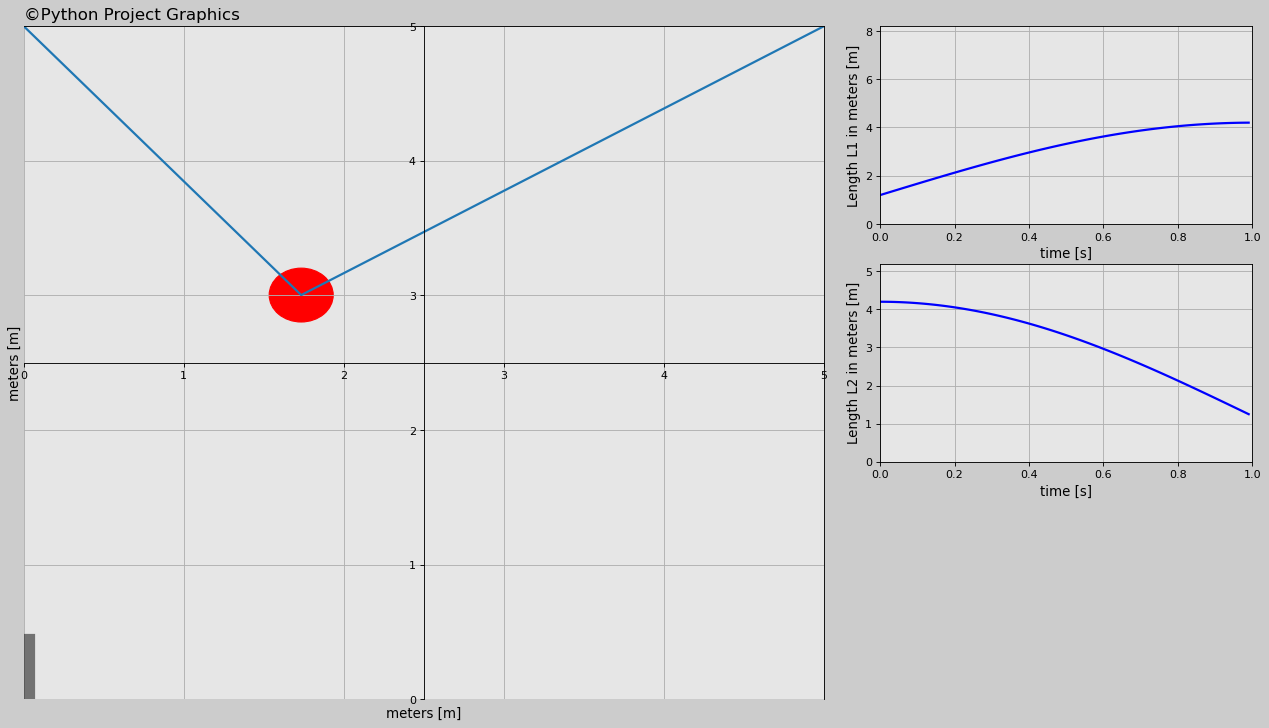

In [9]:
import matplotlib.gridspec as gridspec
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**128
# Animation

# Create the time array
t0=0
t_end=1
dt=0.01
t=np.arange(t0,t_end+dt,dt)

#define the desired length of each cable 
theta1=t*math.pi/2
theta2=t*math.pi/2
l1 = 1.2+3*np.sin(theta1)
l2 = 1.2+3*np.cos(theta2)

def init():
    line.set_data([0,1,5], [5,4,5])
    effector.center=(1,4)
    return (line,effector)

# n_frame=len(forward_model(0,0,l1,l2)[2])
n_frame=len(t)
x_data=np.array([0.,1.,5.])
y_data=np.array([5.,4.,5.])
def animate(i):
    
    x,y = line.get_data()
    x[1] = forward_model2(0,0,l1,l2)[2][i]
    y[1] = forward_model2(0,0,l1,l2)[3][i]
    line.set_data(x, y)
    effector.center=(x[1],y[1])
    eff1=Circle((x[1],y[1]),radius=0.2,color='red')
    l1_fun.set_data(t[0:i],l1[0:i])
    l2_fun.set_data(t[0:i],l2[0:i])
    
    return line,effector,l1_fun, l2_fun

# Define figure properties
fig=plt.figure(figsize=(16,9),dpi=80,facecolor=(0.8,0.8,0.8))
gs=gridspec.GridSpec(3,3)
plt.subplots_adjust(left=0.03,bottom=0.035,right=0.99,top=0.97,wspace=0.15,hspace=0.2)

# Subplot 1
ax1=fig.add_subplot(gs[:,0:2],facecolor=(0.9,0.9,0.9))
base_line,=ax1.plot([0,0],[0,0.4],'k',linewidth=20,alpha=0.5)
ax1.set_xlim(( 0, 5))
ax1.set_ylim((0, 5))
line, = ax1.plot([0,1,5], [5,4,5], lw=2)
effector = Circle((1,4),radius=0.2,color='red')
ax1.add_patch(effector)
ax1.spines['left'].set_position('center')
ax1.spines['bottom'].set_position(('center'))
ax1.xaxis.set_label_coords(0.5, -0.01)
ax1.yaxis.set_label_coords(-0.002, 0.5)
plt.xlim(0,5)
plt.ylim(0,5)
plt.xticks(np.arange(0,5+1,1))
plt.yticks(np.arange(0,5+1,1))
plt.xlabel('meters [m]',fontsize=12)
plt.ylabel('meters [m]',fontsize=12)
plt.grid(True)

copyright=ax1.text(0,5*1.01,'©Python Project Graphics',size=15)

# Subplot 2
ax2=fig.add_subplot(gs[0,2],facecolor=(0.9,0.9,0.9))
l1_fun,=ax2.plot([],[],'b',linewidth=2)
plt.xlim(t0,t_end)
plt.ylim(0,l1[-1]+4)
plt.xlabel('time [s]',fontsize=12)
plt.ylabel('Length L1 in meters [m]',fontsize=12)
plt.grid(True)


# Subplot 3
ax3=fig.add_subplot(gs[1,2],facecolor=(0.9,0.9,0.9))
l2_fun,=ax3.plot([],[],'b',linewidth=2)
plt.xlim(t0,t_end)
plt.ylim(0,l2[-1]+4)
plt.xlabel('time [s]',fontsize=12)
plt.ylabel('Length L2 in meters [m]',fontsize=12)
plt.grid(True)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=n_frame, interval=10, blit=False)

HTML(anim.to_jshtml())